<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/EEG_compare_automated_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated EEG cleaning - A comparison

___
*Dirk Gütlin*

In this notebook, we will take a closer look at automated EEG cleaning algorithms. I will name a range of available methods, select and describe some of them in more detail, apply them using MNE-Python, and finally perform a comparison between them for different analysis tasks.

### Introduction



To this day, EEG cleaning is still an issue and takes up a large amount of time in most EEG analyses. Altough many automated cleaning algorithms have been introduced during the last decades, there is still no widely accepted state-of-the-art method available. This (in my opinion) is at least partially due to a lack of systematic comparisons covering a wide range of automated cleaning procedures and their performance on different parts of the EEG-analysis spectrum. The latter part might be especially important, since modern cleaning algorithms can grow very complex and sometimes researchers might not be sure whether a certain cleaning procedure is actually beneficial, or rather destructive for their analysis objective.

There are also different types of EEG noise. Some types, like noisy channels can be removed relatively effortless by visual inspection, fixed exclusion thresholds, exclusion methods like **RANSAC** (Bigdely-Shamlo et al., 2015; *implemented: [Python](https://autoreject.github.io/generated/autoreject.Ransac.html), [MATLAB](http://vislab.github.io/EEG-Clean-Tools/)*), or even be repaired with methods like **Sensor Noise Suppression** (**SNS**; De Cheveigné & Simon, 2008; *Implemented: [MATLAB](http://audition-backend.ens.fr/adc/NoiseTools/)*).

Frequently reoccuring patterns like blinks, eye movements, or line noise can be removed using **Independent Component Analysis** (**ICA**; Jutten & Herault, 1991; *Implemented: [Python](https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA), [MATLAB A](https://sccn.ucsd.edu/eeglab/index.php), [B](https://www.fieldtriptoolbox.org/reference/ft_componentanalysis/)*), which, as of today, is the most commonly used tool for EEG preprocessing and the only one that has gained general acceptance (as a quasi-standard).

However, there are also less frequently occuring bursts of noise, which will be harder to repair with ICA and (if not removed) can impede the ICA's performance. These sporadic bursts artifacts are mostly created by some type of muscular activity and/or spontaneous movement of the subjects/electrodes.  They are usually removed manually, a process that requires a large amount of time and often accounts for a significant proportion of the entire analysis procedure. Due to the large amount of time spent on this process, there is a relatively strong call throughout the EEG community to automate this process.


___




Numerous algorithms have been proposed for the automated cleaning of burst noise.

Among the currently most prominent algorithms are **AutoReject** (Jas et al., 2016; *Implemented: [Python](https://autoreject.github.io/)*), developed for the MNE-Python framework, and **(riemannian) Artifact Subspace Reconstruction** (**(r)ASR**; Kothe & Makeig, 2013; Blum et al., 2019; *Implemtened: [Python A](https://github.com/DiGyt/mne-python/tree/asr), [B](https://github.com/nbara/python-meegkit), [C](https://github.com/bertrandlalo/timeflux_rasr), [MATLAB](https://github.com/sccn/clean_rawdata)*), which is used as the standard EEG cleaning Addon in the EEGLAB toolbox.

However, there are numerous other algorithms available, which differ in the quality of their applicability, documentation and proof of reliability (in form of publications). Here is a (not necessarily exhaustive) list of cleaning algorithms I found during my research for this notebook (roughly ordered based on my impression of how useful they are). Note that I did not test all of these implementations and can give no precise information on how well or even if some of them work:

- **Riemannian Potato** (Barachant, Andreev & Congedo, 2013; *Implemented:* [Python](https://pyriemann.readthedocs.io/en/latest/generated/pyriemann.clustering.Potato.html))
- **EEG ADJUST** (Mognon et al., 2011, *Implemented:* [Python](https://github.com/mdelpozobanos/eegadjust), [MATLAB](https://www.nitrc.org/projects/adjust/))
- **EEG FASTER** (Nolan, Whelan & Reilly, 2010; *Implemented:* [Python](https://github.com/mdelpozobanos/eegfaster), [MATLAB](https://sourceforge.net/projects/faster/))
- **Sparse Time Artifact Rejection** (**STAR**; De Cheveigné, 2016; *Implemented:* [MATLAB](http://audition-backend.ens.fr/adc/NoiseTools/))
- **EEGExtract** (Saba-Sadiya et al., 2021; *Implemented:* [Python](https://github.com/sari-saba-sadiya/EEGExtract))






There are also more specialized applications which can be used for denoising in specific settings. However, these algorithms come with certain restraints and are no universal noise cleaning techniques. **xDAWN** (Rivet et al., 2009; *Implemented: [Python](https://mne.tools/stable/generated/mne.preprocessing.Xdawn.html)*) for example is a method which specifically aims to improve the signal-to-noise ratio in ERP-based settings for Brain-Computer-Interfaces. It can be used for some special purposes, but is not necessarily applicable to standard experimental EEG settings. **Signal-Space Projection** (**SSP**; Uusitalo & Ilmoniemi,1997; *Implemented: [Python](https://mne.tools/0.16/manual/preprocessing/ssp.html)*) is a technique used to clean data by filtering out external disturbances (like EOG or ECG noise). In order to work, SSP requires a set of data in which the unwanted component is dominantly prevalent (like EOG or ECG electrodes).

There are also aims to improve EEG preprocessing by defining (partially automated) standard pipelines. One widely used pipeline is the **EEG PREP** (Bigdely-Shamlo et al., 2015; *Implemented: [Python](https://github.com/sappelhoff/pyprep), [MATLAB](http://vislab.github.io/EEG-Clean-Tools/)*) which includes several steps like referencing, detrending or channel removal (with **RANSAC**).

Unfortunately, the cleaning algorithms described above are implemented in many different ways, and even if there exists a Python version of a specific algorithm, it is not necessarily easily applicable to the MNE-Python workflow. For this purpose, I will base my further analysis and comparison on the four algorithms that are actually easily available and simple to use with MNE-Python, which are AutoReject, the Riemannian Potato, ASR, and xDAWN.

First of all, here is a small overview of some features that can be important when selecting an automated cleaning algorithm.

|                          | AutoReject | R. Potato  | (r)ASR     | XDawn      |
| ------------------------ | ---------- | ---------- | ---------- | ---------- |
| Year of publication      | 2017       | 2013       | 2013/19    | 2009       |
| Exclude data             | &#10003;  | &#10003;  | &#10003;$^1$ | &#10007;  |
| Interpolate data         | &#10003;  | &#10007;  | &#10003;  | &#10003;  |
| PCA-based interpolation  | &#10007;  | &#10007;  | &#10003;  | &#10003;  |
|Simple exclusion threshold| &#10003;  | &#10003;  | &#10007;$^2$  | &#10007;  |
|  Works on raw data       | &#10003;$^3$| &#10003;$^3$| &#10003;  | &#10007;  |
|  Works on epoched data   | &#10003;  | &#10003;  | &#10003;$^1$| &#10003;  |
|Easily/universally applicable| &#10003;  | &#10003;  | &#10003;  | &#10007;  |
| MATLAB version available | &#10007;  | &#10007;  | &#10003;  | &#10003;  |
| Python version available | &#10003;  | &#10003;  | &#10003;$^4$| &#10003;  |


___
1. Theoretically working, but not yet implemented in the version which is used here.
2. Exclusion threshold theoretically comprehensive, but can practically change across segments.
3. Works only by artificially epoching raw data.
4. Currently, only standard ASR is available in the version which is used here.

In the following parts of this notebook, I will describe and apply these 4 selected cleaning procedures to an example dataset, and later try to compare them based on their performance for different EEG analysis objectives.

### Install toolboxes


If you're running this notebook from Google Colab, we can install the required packages out of our Python shell. If you're running this in a personal environment, please make sure to install the following requirements:

- [my ASR fork of MNE-Python](https://github.com/DiGyt/mne-python.git@asr)
- AutoReject
- pyriemann

- numpy
- sklearn
- matplotlib

In [ ]:
!pip install mne==1.3.1 -q
!pip install asrpy -q
!pip install autoreject -q
!pip install pyriemann -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### Import data

After installation, we can import all the libraries that we need for data wrangling, cleaning, and evaluation.

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

import mne
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import sample, eegbci, ssvep
from mne.preprocessing import Xdawn

from asrpy import ASR
from autoreject import AutoReject
from pyriemann.clustering import Potato
import pyriemann

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP, Vectorizer

mne.utils.check_random_state(26042021)

RandomState(MT19937) at 0x7F738510C440

Since we want to at least have a very small amount of generalization, I designed this notebook in a way which allows you use different datasets. For this purpose, we define a function called `load_dataset`, which will load one of these three EEG datasets: "eegbci", "audvis", or "ssvep". All of them are based on different experimental paradigms and laboratory settings and therefore allow us to generalize our results a little better.

In [ ]:
def load_dataset(dataset):

  if dataset == "eegbci":

    # define the data to load
    subject = 1
    runs = [5, 9, 13] # [5, 9, 13] # [6, 10, 14]  # motor imagery: hands vs feet

    # load the raw data
    raw_fnames = eegbci.load_data(subject, runs)
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])

    # strip channel names of "." characters
    eegbci.standardize(raw)  # set channel names
    raw.rename_channels(lambda x: x.strip('.'))

    # set a standard 10-05 montage
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage)

    # extract the events
    events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))
    event_id = {'Hand': 2, 'Feet': 3}

  elif dataset == "audvis":

    # load the data
    data_path = sample.data_path()
    raw_fname = str(data_path) + '/MEG/sample/sample_audvis_raw.fif'
    raw = mne.io.read_raw_fif(raw_fname, preload=True)


    # extract the events
    event_fname = str(data_path) + '/MEG/sample/sample_audvis_raw-eve.fif'
    events = mne.read_events(event_fname)
    event_id = {'visual/right': 4, 'auditory/right': 2}
    # you could also choose one of these options
    #event_id = {'auditory/left': 1, 'auditory/right': 2,
    #            'visual/left': 3, 'visual/right': 4}

  elif dataset == "ssvep":

    # Load raw data
    data_path = ssvep.data_path()
    raw_fname = str(data_path) + '/sub-02/ses-01/eeg/sub-02_ses-01_task-ssvep_eeg.vhdr'
    raw = mne.io.read_raw_brainvision(raw_fname, preload=True, verbose=False)

    # Set montage
    montage = mne.channels.make_standard_montage('easycap-M1')
    raw.set_montage(montage, verbose=False)

    # Construct epochs
    event_id = {'12hz': 255, '15hz': 155}

    events, _ = mne.events_from_annotations(raw, verbose=False)

  features = list(event_id.keys())


  return raw, events, event_id, features

First of all, we load one of the available datatsets.

In [ ]:
# possible datasets: ["audvis", "eegbci", "ssvep"]
raw, events, event_id, features = load_dataset("eegbci")

# display some properties of our dataset
raw

Using default location ~/mne_data for EEGBCI...
Creating ~/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? n


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? n


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? n
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T2']


<RawEDF | S001R05.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

We will start with some standard preprocessing of the respective dataset. Picking EEG channels, filtering, and extracting epochs from our data. Note that some of the cleaning algorithms will be fit to the raw data, while others will use the epoched data. This depends on the design of the cleaning algorithm and will not affect our abiltiy to compare the data (as long as there are no further changes made to the `raw` and `epochs` objects afterwards).

In [ ]:
# pick only EEG channels (no MEG, EOG or other channels)
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False)
raw.pick(picks)

# filter the data between 1 and 75 Hz
raw.filter(l_freq=1., h_freq=None, fir_design='firwin',
           skip_by_annotation='edge')

# set the start and end time of the epochs we want to investigate
tmin = -0.2
tmax = 1.5

# create epochs around the events we extracted from our data
epochs = mne.Epochs(raw, events, event_id, tmin, tmax,
                    baseline=None, reject=None,
                    verbose=False, detrend=0, preload=True)

Filtering raw data in 3 contiguous segments
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


We can check how many events were extracted from the respective dataset by calling our `epochs` object.

In [ ]:
epochs

Number of events,45
Events,Feet: 22Hand: 23
Time range,-0.200 – 1.500 sec
Baseline,off


### AutoReject

AutoReject (AR) was designed to automatically find the best threshold for rejection and reparation of segments, without requiring the researcher to adjust further parameters (and therefore be easily applicable). So, in contrast to other cleaning algorithms, you won't have to define some threshold of rejection (although there are parameters that allow you to influence the process).

AutoReject works in two main steps: *Global AutoReject* and *Local AutoReject*. 

- During global AutoReject, the best global rejection threshold is found by applying a grid search which aims to minimize the difference between the mean of the good signals and the median of all signals (i.e. trying to bring the overall median closer to the mean of the good signals).

- Afterwards, local AutoReject is used to repair or exclude trials. Each sensor in a trial is ranked based on their peak-to-peak amplitude. If too many sensors in one trial are bad, the entire trial will be rejected. If only a part of sensors are bad, they will be repaired by spatially interpolating them from the good sensors.



In [ ]:
# suppress AR's output to save some space.
# This works better in Colab than setting AR's verbosity level.
%%capture

# set parameters for autoreject
n_interpolates = np.array([1, 4, 32])
consensus_percs = np.linspace(0, 1.0, 11)
ar = AutoReject(n_interpolates, consensus_percs, random_state=26042021)

# fit the autoreject channel thresholds and bad epochs
ar.fit(epochs)

# transform the epochs, excluding/interpolating bad epochs
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

We can investigate the rejected epochs by plotting the rejection log produced by AutoReject.

Using matplotlib as 2D backend.


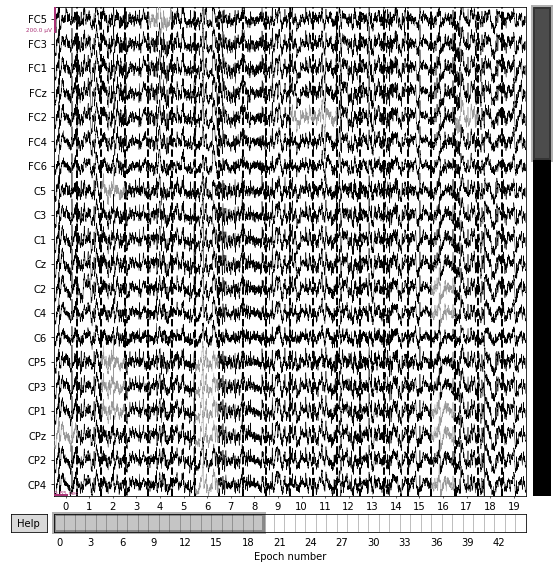

In [ ]:
# visualize the rejected epochs
reject_log.plot_epochs(epochs, scalings={"eeg":1e-4});

### Riemannian Potato

The Riemannian Potato has not only a great name, but also follows a relatively simple yet effective procedure.

First of all, it calculates the covariance matrices for all trials. Then, a central covariance matrix is defined (e.g. represented by the black dot in the figure below). Together with a distance threshold, this central matrix then creates a volume in space (similar to what you see below). Basically it's the same like creating a sphere through a point and a radius in euclidean space, just that in riemannian space this sphere often looks much more like a potato. Finally, every trial with a covariance matrix outside of the potato (i.e. with a larger riemannian distance than defined by the threshold) is rejected.

<img src="https://d3i71xaburhd42.cloudfront.net/0f0901f4f302fb29df6761de47adb39f8e2d4758/3-Figure1-1.png"
     alt="Figure: Graphical display of the Riemannian Potato" />

In [ ]:
# estimate the covariance matrices from our epochs
covs = pyriemann.estimation.Covariances(estimator="lwf")
cov_mats = covs.fit_transform(epochs.get_data())

# Define the riemannian potato object. We use a threshold of 2 std's here.
# With larger thresholds it might occur that no data is excluded at all
potato = pyriemann.clustering.Potato(threshold=2)

# Fit the Potato
potato.fit(cov_mats)

# Get the clean epoch indices and select only these for further processing
clean_idx = potato.predict(cov_mats).astype(bool)
epochs_rp = epochs.copy()[clean_idx]

### Artifact Subspace Reconstruction

Artifact Subspace Reconstruction (ASR) can be used as an offline (for standard experiments) or online (for e.g. Brain-Computer-Interfaces) method.

Generally, ASR first learns a robust distribution of clean data components by looking at covariance matrices of small segments of the data. When processing data, it then goes again through small segments of data and repairs/removes them if they lie outside of the fitted distribution.

Under the hood, the method is a little more complicated. First, the data is filtered with a Yule-Walker Filter. When going through the segments during transformation, a temporally smoothed version of the covariance matrix is compared to the fitted boundaries. If some components are outside of the allowed boundaries, these components are then reconstructed (by using a mixing matrix created during fitting) and filled into the data using cosine blending.

The riemannian variant (rASR) is an improved method which uses riemannian geometry to estimate the eigenspace and centroids of the covariance matrices. Unfortunately, it is not yet available with this implementation.

In [ ]:
# define the needed variables from our dafta
sfreq = raw.info["sfreq"]
data = raw.get_data()

# define the ASR object with standard parameters
asr = ASR(sfreq=sfreq, cutoff=5)

# fit it to the first 100 seconds of the recording
asr.fit(raw.copy().crop(tmax=100))

# create a copy of our data and fill in the ASR cleaned data

raw_asr = asr.transform(raw)

# create epochs from the cleaned data
epochs_asr = mne.Epochs(raw_asr, events, event_id, tmin, tmax, baseline=None,
                        reject=None, verbose=False, detrend=0, preload=True)

Let's investigate how ASR repaired our data by plotting it before and after ASR cleaning.

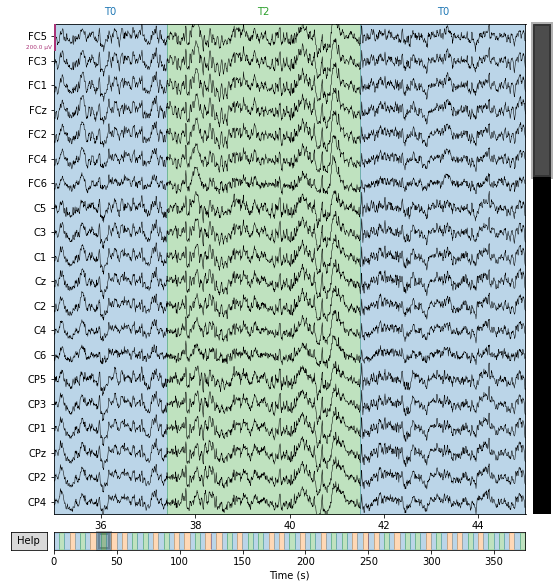

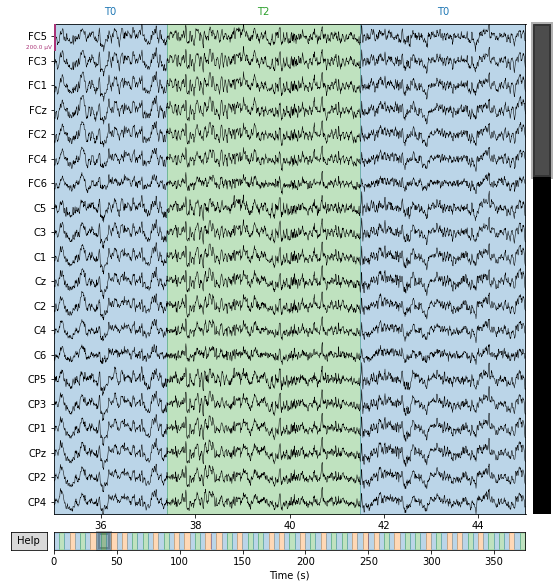

In [ ]:
# define the temporal window and unit scale we want to investigate
start = 35
duration = 10
scalings = {"eeg":1e-4}

# plot the uncleaned data compared to the ASR cleaned data
raw.plot(start=start, duration=duration, scalings=scalings, title="raw");
raw_asr.plot(start=start, duration=duration, scalings=scalings,
             title="after ASR");

### xDAWN

First of all: **xDAWN is no general purpose cleaning algorithm and can not be used like that.** xDAWN was developed for BCI applications and is a method to enhance evoked potentials. It can be used for denoising (like in [this MNE-Tutorial](https://mne.tools/stable/auto_examples/preprocessing/xdawn_denoising.html?highlight=xdawn) ) if you want to work with anything ERP-related. However, it is not entirely data agnostic (as it requires knowledge about the condition evoking a certain ERP) and will create a separate transformation for every condition included.

xDAWN was specificially designed to maximize the signal to noise ratio for a certain ERP component. Under the hood, it uses PCA and Spatial Filters to reach that goal. Therefore you should be careful when trying to use it with ICA or methods like Common Spatial Filters (CSP), since xDAWN changes the number of components and therefore the rank of your data.

In [ ]:
# Estimates signal covariance
signal_cov = mne.compute_raw_covariance(raw)
xd = Xdawn(n_components=30, signal_cov=signal_cov)
xd.fit(epochs)
epochs_xdawn = xd.apply(epochs)


Using up to 1875 segments
Number of samples used : 60000
[done]
Computing rank from data with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 34 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 34 Xdawn components
Inverse transforming to sensor space


We can visualize the effects of xDAWN by plotting the ERP. You can get an intuition for what the algorithm does by re-running xDAWN with 1 or 2 components only and plotting the results.

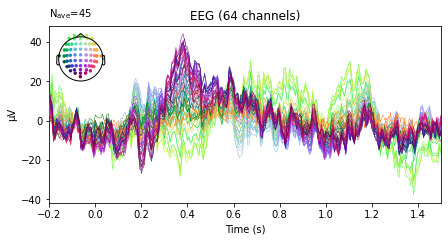

In [ ]:
epochs_xdawn[features[0]].average().plot(spatial_colors=True);

### Comparison

Now, we can try to compare how beneficial our cleaning procedures were. This is a hard task, since it is not easy to define the quality of a signal, especially in EEG, where different "qualities" of the same signal are required depending on the task (e.g. a signal's ERP vs. its frequency spectrum). Another problem is that we cannot distinguish what part of the signal is "true signal" (i.e. brain activity) and which part is noise, since during measurement they always occur in combination. One method of trying to find the "Signal-to-Noise" ratio is by assuming the true underlying signal to be the signal which comes out if we record many repetitions of the same event and then average them. This definition of "Signal-to-Noise" is perfectly equivalent with our idea of ERPs. Therefore this measure is a good proxy for signal quality when it comes to increased activity in the brain that is reliably evoked from a certain stimulus. At the same time, it is a very bad proxy for signal quality if you're interested in genuine brain activity of more variable states, like oscillations, which might simply cancel out during averaging.

Since we want to investigate general-purpose performance of our cleaning algorithms, we will not only refer to the above mentioned Signal-to-Noise ratio, but also use decoding performance in different setting as a measure of signal improvement. Modern brain decoding techniques are highly sensitive and we can assume their decoding performance on a specific task to broadly reflect the amount of information present in the underlying data. We can use this fact and see how well a certain decoding technique can categorize between two brain conditions after different transformations like Time-Frequency-Transforms or Spatial Filtering. If our cleaning algorithm improved our signal, this should also improve the decoding accuracy between two conditions.

In the following I will compute various of these measures on all selected cleaning algorithms and later compare them.

First, we define a function that gives us the above mentioned Signal-to-Noise ratio. Then we apply it to our data and investigate the results.

In [ ]:
def SNR(x, y=None, axis=0):
    """Signal to Noise Ratio, as defined here:
    www.scholarpedia.org/article/Signal-to-noise_ratio_in_neuroscience

    This is equivalent to the variance of the average signal in relation to the 
    total variance.

    Parameters
    ----------
    x : array of any shape
        An array representing a set of signals. The last dimension in the array
        must correspond to the time course of the signal (over which the common
        underlying signal is expected).
    y : None, array of shape == x.shape
        Reference array that will be used for computation of the underlying
        signal. If y = None, x is used as reference array. Defaults to None.
    axis : int or tuple of ints
        The axes over which the signals should be averaged to get the common
        underlying signal. Can include every axis of the array except for the 
        last one, which is assumed to be the time axis of the signal.
        Defaults to 0.

    Returns
    -------
    SNR : float or array of floats
        The signal-to-noise ration over the remaining axes. Is equivalent to 
        the fraction of how much of the total variance in the signal set is
        explained through the common underlying signal.
    """
    y = x if y is None else y
    axis = tuple([axis]) if isinstance(axis, int) else axis
    if np.any([ax in axis for ax in [-1, x.ndim - 1]]):
        raise ValueError("Last array axis can't be passed as axis argument.")
    return np.mean(np.mean(y, axis)**2, axis=-1) / np.var(x, axis=(-1,) + axis)

In [ ]:
# decide which event we want to investigate for our ERPs
event = features[0]

# get some lists that combine the preprocessed data
var_names = ["uncleaned", "AutoReject", "Potato", "ASR", "XDawn"]
epoch_list = [epochs, epochs_ar, epochs_rp, epochs_asr, epochs_xdawn[event]]

# calculate the signal to noise ratio for all pipelines
avg_list = [SNR(ep[event].get_data(), axis=0) for ep in epoch_list]

Let's visualize the SNR by plotting the distribution across channels (with mean indicated).

In [ ]:
# plot SNR
plt.violinplot(avg_list, showmeans=True)
plt.title('Distribution of signal to noise ratios across channels.')
plt.xticks(ticks=np.arange(len(var_names))+1, labels=var_names);
plt.ylabel("SNR distribution across channels")

Text(0, 0.5, 'SNR distribution across channels')

We can also plot the SNR in relation to uncleaned data to see how much it has improved.

In [ ]:
# plot SNR compared to uncleaned
plt.violinplot([avg/avg_list[0] for avg in avg_list], showmeans=True)
plt.title('Improvement compared to uncleaned data')
plt.xticks(ticks=np.arange(len(var_names))+1, labels=var_names)
plt.ylabel("SNR distribution across channels\n in relation to uncleaned data");

We already see that most algorithms improved the SNR to a certain degree. xDAWN by far exceeds the other algorithms on this task, which is no surprise as it was specifically designed for this purpose. Also ASR actually seems to perform worse than our uncleaned data. If we plot the ERPs of our data (below), we see that ASR has notably levelled out the amplitude of our ERP and has completely removed a second component which is occuring in the frontal regions at a later timepoint. However, it's still hard to say if this transformation is justified from looking at the ERPs only.

In [ ]:
# get the evokeds
evokeds = [ep.average() for ep in epoch_list]

# plot the ERPs after each different cleaning procedure
fig,axes = plt.subplots(1, 5, figsize=[24, 5], sharey=True)
for ax, ev, name in zip(axes,  evokeds, var_names):
    ev.plot( axes=ax, titles=name, show=False, spatial_colors=True)
fig.show()

Now let's look at decoding performances.

First of all, we remain with the ERP-based approach and decode the two extracted experimental conditions based on the epochs average voltage over time (so averaged across channels). We use Support Vector Classification with Radial Basis Function as our classifier, since it is a highly performant machine learning technique and can also handle nonlinear relations.

In [ ]:
for name, ep in zip(var_names, epoch_list):

  clf = Pipeline([("Vec", Vectorizer()), ("SVC", SVC())])

  x = ep.get_data().mean(axis=1)
  print(x.shape)
  y = ep.events[:, -1]

  cv = StratifiedShuffleSplit(20, test_size=0.2, random_state=26042021)
  scores = cross_val_score(clf, x, y, cv=cv)

  print("Classification performance: {0} - {1:.3f}".format(name, scores.mean()))

(45, 273)
Classification performance: uncleaned - 0.494
(45, 273)
Classification performance: AutoReject - 0.506
(41, 273)
Classification performance: Potato - 0.556
(45, 273)
Classification performance: ASR - 0.439
(45, 273)
Classification performance: XDawn - 0.522


Then we can look at decoding performance on entire epochs (without averaging).

In [ ]:
mne.set_log_level(verbose="Warning")

for name, ep in zip(var_names, epoch_list):

  clf = Pipeline([("Vec", Vectorizer()), ("SVC", SVC())])

  x = ep.get_data()
  y = ep.events[:, -1]

  cv = StratifiedShuffleSplit(20, test_size=0.2, random_state=26042021)
  scores = cross_val_score(clf, x, y, cv=cv)

  print("Classification performance: {0} - {1:.3f}".format(name, scores.mean()))

Classification performance: uncleaned - 0.550
Classification performance: AutoReject - 0.550
Classification performance: Potato - 0.561
Classification performance: ASR - 0.472
Classification performance: XDawn - 0.611


A more contrastive measure would be the decoding performance based on a Time-Frequency Analysis.

In [ ]:
for name, ep in zip(var_names, epoch_list):
  clf = Pipeline([("Vec", Vectorizer()), ("SVC", SVC())])

  x = ep.compute_psd(method="welch", n_fft=32).get_data()
  y = ep.events[:, -1]

  cv = StratifiedShuffleSplit(20, test_size=0.2, random_state=26042021)
  scores = cross_val_score(clf, x, y, cv=cv)

  print("Classification performance: {0} - {1:.3f}".format(name, scores.mean()))

Classification performance: uncleaned - 0.539
Classification performance: AutoReject - 0.539
Classification performance: Potato - 0.611
Classification performance: ASR - 0.561
Classification performance: XDawn - 0.533


Finally, we can look at decoding performance in a more spatially dissolved manner, using the Common Spatial Patterns decoder from MNE + Linear Discriminant Analysis.

In [ ]:
for name, ep in zip(var_names, epoch_list):
  if name == "XDawn":
    print("CSP measure not available for XDawn. XDawn data has already removed "
    "spatial components and therefore has a lower rank than CSP requires. "
    "Continuing.")
    continue
  csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
  lda = LinearDiscriminantAnalysis()

  clf = Pipeline([('CSP', csp), ('LDA', lda)])

  x = ep.get_data()
  y = ep.events[:, -1]

  cv = StratifiedShuffleSplit(20, test_size=0.2, random_state=26042021)
  scores = cross_val_score(clf, x, y, cv=cv)

  print("Classification performance: {0} - {1:.3f}".format(name, scores.mean()))

Classification performance: uncleaned - 0.589
Classification performance: AutoReject - 0.561
Classification performance: Potato - 0.622
Classification performance: ASR - 0.717
CSP measure not available for XDawn. XDawn data has already removed spatial components and therefore has a lower rank than CSP requires. Continuing.


To make a more general comparison between performance of these cleaning algorithm, I've run the above code for different datasets and objectives (note that main focus here was to get as many different settings as possible, therefore it is not perfectly balanced):

| Dataset   | Subject (Total Subject) | Task description and conditions |
| ----------| ------------ | ------------------------------- |
|"EEGBCI"   |Subject 1 (1) |Motor execution - hands vs feet|
|"EEGBCI"   |Subject 1 (1) |Motor imagery - hands vs feet|
|"EEGBCI"   |Subject 2 (2) |Motor execution - hands vs feet|
|"EEGBCI"   |Subject 2 (2) |Motor imagery - hands vs feet|
|"AudVis"   |Subject 1 (3) |Sensory - visual left vs visual right|
|"AudVis"   |Subject 1 (3) |Sensory - auditory left vs auditory right|
|"AudVis"   |Subject 1 (3) |Sensory - auditory vs visual|
|"SSVEP"    |Subject 1 (4) |Visual perception - 12 Hz vs 15 Hz pattern|
|"SSVEP"    |Subject 2 (5) |Visual perception - 12 Hz vs 15 Hz pattern|

<br/><br/>

 Below you can see the average performances resulting from all cleaning algorithms applied to all datasets:

A. Mean (and standard deviaton) of performance for the described cleaning algorithms on different task.


|             | Uncleaned  | AutoReject | R. Potato  | ASR        | XDawn      |
| ------------| ---------- | ---------- | ---------- | ---------- | ---------- |
|(mean-based) SNR|0.027 (0.016)|0.031 (0.016)|0.035 (0.019)|0.021 (0.009)|0.039 (0.020)|
|AVG Decoding |0.527 (0.092)|0.538 (0.098)|0.557 (0.091)|0.522 (0.099)|0.590 (0.127)|
|Full Decoding|0.606 (0.119)|0.603 (0.129)|0.613 (0.105)|0.602 (0.124)|0.704 (0.126)|
|TFR Decoding |0.559 (0.163)|0.559 (0.143)|0.596 (0.186)|0.604 (0.174)|0.557 (0.162)|
|CSP Decoding |0.594 (0.178)|0.585 (0.188)|0.670 (0.196)|0.673 (0.222)| -----      |

<br/><br/>

B. Performance improvement on different tasks as a ratio to uncleaned data performance.




|             | Uncleaned  | AutoReject | R. Potato  | ASR        | XDawn      |
| ------------| ---------- | ---------- | ---------- | ---------- | ---------- |
| SNR         |1.000       |1.148       |1.296       |0.777       |1.444       |
|AVG Decoding |1.000       |1.021       |1.057       |0.991       |1.121       |
|Full Decoding|1.000       |0.995       |1.012       |0.993       |1.162       |
|TFR Decoding |1.000       |1.000       |1.066       |1.081       |0.996       |
|CSP Decoding |1.000       |0.984       |1.128       |1.133       |-----       |

<br/><br/>

**Note**: The sample size for this comparison is still very small with N=5 subjects and 9 different analyses in total. Also note that none of these recordings contain excessive noise and that results might look different for noisier recordings. Finally, in many standard analyses, ICA is used as an additional cleaning step. Some of these cleaning algorithms might work better in combination with ICA than others.

However, as far as this table allows any conclusions, we could say the following about the cleaning algorithms:


- **AutoReject** is an acceptable choice for ERP-based analyses, especially if you're not sure about setting a specific exclusion threshold and want to keep a good overview over what has been changed on your data. However, it doesn't seem to notably improve decoding performance on non-average decoding tasks. Note that with AutoReject you can do interpolation and exclusion, which can come handly in some situations.


- The **Riemannian Potato** looks like a surprisingly good (and simple) solution for all of the tasks *if* you set a good threshold. Note that your perfect threshold might vary depending on your task and data. Also the Riemannian Potato can only exclude data and has no option for interpolation, which might be necessary for some tasks.


- **Artifact Subspace Reconstruction** might be a good choice if you want to keep all of your data, e.g. in complex dependent designs, where throwing away small segments leads to heavy losses. As we can see, ASR performs well on some of the decoding tasks. However, it actually seems to perform worse when it comes to ERP-based designs (as it is not directly optimized towards that measure). While the raw data application and full interpolation leads to minimum data loss, it should also be noted that ASR interpolates your data in more complex way, which you might want to omit in some situations.


- **xDAWN** performs great on ERP and sample-space decoding tasks. This is to be expected, since we allow the procedures to apply different transformations to different conditions. This is great for "engineering" tasks, but not necessarily useful for classical experiments and statistical comparisons. Also, due to its ERP-focussed design it does not really perform well on TFR-based decoding. It also is not always compatible with ICA and other rank-dependent procedures. While it's definitely useful as a standalone application in BCI, it has restricted use for classical analysis.

Although this comparison already should give a useful insight into cleaning performances, it would always be helpful to have more data at hands (especially more noisy data). It also would be great to include further cleaning algorithms, given that their implementation is affordable enough.

### References

- Barachant, A., Andreev, A., & Congedo, M. (2013). The Riemannian Potato: an automatic and adaptive artifact detection method for online experiments using Riemannian geometry. In TOBI Workshop lV (pp. 19-20).

- Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K. M., & Robbins, K. A. (2015). The PREP pipeline: standardized preprocessing for large-scale EEG analysis. Frontiers in neuroinformatics, 9, 16.

- Blum, S., Jacobsen, N. S., Bleichner, M. G., & Debener, S. (2019). A Riemannian modification of artifact subspace reconstruction for EEG artifact handling. Frontiers in human neuroscience, 13, 141.

- De Cheveigné, A. (2016). Sparse time artifact removal. Journal of neuroscience methods, 262, 14-20.

- De Cheveigné, A., & Simon, J. Z. (2008). Sensor noise suppression. Journal of Neuroscience Methods, 168(1), 195-202.

- Jas, M., Engemann, D. A., Bekhti, Y., Raimondo, F., & Gramfort, A. (2017). Autoreject: Automated artifact rejection for MEG and EEG data. NeuroImage, 159, 417-429.

- Jutten, C., & Herault, J. (1991). Blind separation of sources, part I: An adaptive algorithm based on neuromimetic architecture. Signal processing, 24(1), 1-10.

- Kothe, C. A., & Makeig, S. (2013). BCILAB: a platform for brain–computer interface development. Journal of neural engineering, 10(5), 056014.

- Mognon, A., Jovicich, J., Bruzzone, L., & Buiatti, M. (2011). ADJUST: An automatic EEG artifact detector based on the joint use of spatial and temporal features. Psychophysiology, 48(2), 229-240.

- Nolan, H., Whelan, R., & Reilly, R. B. (2010). FASTER: fully automated statistical thresholding for EEG artifact rejection. Journal of neuroscience methods, 192(1), 152-162.

- Rivet, B., Souloumiac, A., Attina, V., & Gibert, G. (2009). xDAWN algorithm to enhance evoked potentials: application to brain–computer interface. IEEE Transactions on Biomedical Engineering, 56(8), 2035-2043.

- Saba-Sadiya, S., Chantland, E., Alhanai, T., Liu, T., & Ghassemi, M. M. (2021). Unsupervised EEG Artifact Detection and Correction. Frontiers in Digital Health, 2, 57.

- Uusitalo, M. A., & Ilmoniemi, R. J. (1997). Signal-space projection method for separating MEG or EEG into components. Medical and Biological Engineering and Computing, 35(2), 135-140.